# Treinamento regressão

In [1]:
treinar = {
    'GP': False,
    'RegressaoLinear': True,
    'BayesianPolinomialLinearRegression': True,
    'BayesianLinearRegression': True,
    'RBFLinearRegression': True,
}

In [2]:
# Fold em que o código será executado
# Selecione: inteiro no intervalo [0 e 4]
fold_externo = 0

# Métrica da otimização bayesiana
# Selecione: rmse, nlpd
metrica = 'rmse'

## Conjunto de dados

In [3]:
import numpy as np
import pandas as pd

dataset = pd.read_csv('housesToRentProcessed.csv', index_col=0)

X = dataset[[
    'São Paulo', 'Porto Alegre', 'Rio de Janeiro', 'Campinas', 'Belo Horizonte', 
    'area',
    'rooms', 'bathroom', 'parking spaces', 'floor', 'isHouse', 'animal', 'furniture',
]].values
y = dataset[['y con + alu']].values

### Descrição do conjunto de dados

| Atributo         | Descrição                                           | Valor  |
| ---------------- | --------------------------------------------------- | ------ |
| `São Paulo`      | Imóvel está localizado na cidade de São Paulo?      | `int: 0 false - 1 true` |
| `Porto Alegre`   | Imóvel está localizado na cidade de Porto Alegre?   | `int: 0 false - 1 true` |
| `Rio de Janeiro` | Imóvel está localizado na cidade de Rio de Janeiro? | `int: 0 false - 1 true` |
| `Campinas`       | Imóvel está localizado na cidade de Campinas?       | `int: 0 false - 1 true` |
| `Belo Horizonte` | Imóvel está localizado na cidade de Belo Horizonte? | `int: 0 false - 1 true` |
| `area`           | Área do imóvel (em metros quadrados)                | `float` |
| `rooms`          | Quantidade de quartos                               | `int` |
| `bathroom`       | Quantidade de banheiros                             | `int` |
| `floor`          | Andar localizado o imóvel                           | `int`. `0` pressuposto para casa |
| `isHouse`        | Imóvel corresponde a um aluguel de casa             | `int: 0 false - 1 true` |
| `animal`         | É possivel levar animais para o imóvel              | `int: 0 false - 1 true` |
| `furniture`      | ?                      | `int: 0 false - 1 true` |
| `y con + alu`    | Valor mensal total do aluguel do imóvel: aluguel + taxa de condomínio. | `float` |

In [4]:
dataset.head()

,São Paulo,Porto Alegre,Rio de Janeiro,Campinas,Belo Horizonte,area,rooms,bathroom,parking spaces,floor,isHouse,animal,furniture,y con + alu
3489,0,0,0,1,0,69,2,2,1,14,0,1,0,2125
669,1,0,0,0,0,450,4,5,6,1,1,1,0,12000
6003,0,0,0,0,1,61,3,1,1,2,0,1,0,1800
5333,1,0,0,0,0,54,2,2,1,2,0,1,0,2327
1524,0,0,0,1,0,85,3,2,1,7,0,1,0,2415


### Separação de treino e teste

Os dados foram separados em treino e em teste seguindo a proporção de $70\%$ para treino e de $30\%$ para testes. O processo de seleção do modelo será descrito posteriormente.

In [5]:
from trabalho.util.kfold import get_fold

_, X_train, X_test, y_train, y_test = get_fold(fold_externo, n_splits=5, X=X, y=y)

#X_train = X_train[:5]
#y_train = y_train[:5]

print('Quantidade de elementos para o treinamento:', X_train.shape)
print('Quantidade de elementos selecionados para teste:', X_test.shape)

Quantidade de elementos para o treinamento: (8550, 13)
Quantidade de elementos selecionados para teste: (2138, 13)


### Normalização

A normalização aplicada no conjunto de dados foi a [min/max scalling](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler):
\begin{aligned}
\mathcal{D}_{std} &= \frac{\mathcal{D} - \mathcal{D}.min(axis=0)}{\mathcal{D}.max(axis=0) - \mathcal{D}.min(axis=0)}; \\
\mathcal{D}_{scaled} &= \mathcal{D}_{std} \cdot (max - min) + min.
\end{aligned}
A transformação aplicada, escala (dimensiona) e translada cada característica individualmente, de modo que esta esteja entre o intervalo $[0, 1]$.

Como poderá ser visto adiante, este trabalho tomou o cuidado dos dados de validação e de teste serem transformados conforme os dados  a escala definida no treinamento.

In [6]:
from sklearn.preprocessing import MinMaxScaler

Scaler = MinMaxScaler

## Treinamento

Com o intuito de selecionar os melhores hiperparâmetros, para cada um dos modelo testados, foi realizado uma validação cruzada por meio de _5-folds_, onde ocorreu uma otimização bayesiana em cada um dos _folds_. Os hiperparâmetros foram selecionados de acordo com o resultado da métrica **DECIDIR**, descrita adiante neste trabalho.

Após a seleção dos hiperparâmetros, cada um dos modelos foram avaliados com conjunto de testes por meio das métricas descritas a seguir.

### Métricas

#### Root Mean Squared Error (RMSE)

__Root Mean Squared Error__ ou raiz do erro quadrático médio [_terminar_]

\begin{aligned}
\text{MSE}(\boldsymbol{y}, \hat{\boldsymbol{y}}) &= \frac{1}{N_\text{teste}} \sum_{i=1}^{N_\text{teste}} (y_i - \hat{y}_i)^2; \\
\text{RMSE}(\boldsymbol{y}, \hat{\boldsymbol{y}}) &= \sqrt{\text{MSE}(\boldsymbol{y}, \hat{\boldsymbol{y}})}
\end{aligned}

In [7]:
from trabalho.util.metrica import rmse

#### Negative Log Predictive Density (NLPD)

A métrica **Negative Log Predictive Density** (NLPD) leva em consideração a variância predita $\hat{\sigma}_i^2$, além dos valores esperados e preditos (média):

\begin{aligned}
\text{NLPD}
&= -\frac{1}{N_\text{teste}}
    \sum_{i=1}^{N_\text{teste}}
    \log 
    \overbrace{p(y_i|\boldsymbol{x}_i, \boldsymbol{y}, \boldsymbol{X}, \hat{\boldsymbol{\theta}})}^{\mathcal{N}(y_i|\hat{\mu}_i, \hat{\sigma}_i^2)}
    \\
&= \frac{1}{2}\log2\pi + \frac{1}{2 N_\text{teste}}
\sum_{i=1}^{N_\text{teste}} \left[\log \hat{\sigma}^2_i + \frac{(y_i - \hat{\mu}_i)^2}{\hat{\sigma}^2_i}\right]
\end{aligned}

Conforme já discutido em aula, a NLPD busca realçar modelos equilibrandos, penalizando:
* modelos muito confiantes nos casos de erros grandes ($\sigma^2_i$ baixos para erros maiores), e;
* modelos pouco confiantes nos casos de erros pequenos ($\sigma^2_i$ altos para erros menores).

In [8]:
from trabalho.util.metrica import nlpd

## Modelos utilizados

In [9]:
relatorio_modelos = pd.DataFrame(columns=['modelo', 'parametros', 'rmse', 'nlpd', 'fold'])

### Processos Gaussianos

In [10]:
from trabalho.modelos.gp import GP

GP

trabalho.modelos.gp.GP

#### Hiperparâmetros a serem procurados

In [11]:
from trabalho.util.otimizacao_bayesiana import Dominio
import gpflow


kernels = [
    # Combinação de kernels
    #gpflow.kernels.Combination(),
    #gpflow.kernels.ChangePoints(),
    #gpflow.kernels.Product(),
    #gpflow.kernels.Sum(),
    
    # Imagem (convolução)
    #gpflow.kernels.Convolutional(),
    
    # Dados estacionários
    #gpflow.kernels.Stationary(),
    #gpflow.kernels.Periodic(), # Can be used to wrap any Stationary kernel to transform it into a periodic version
    #gpflow.kernels.AnisotropicStationary(), 
    #gpflow.kernels.IsotropicStationary(),
    
    # Multi objetivo
    #gpflow.kernels.MultioutputKernel(),
    #gpflow.kernels.IndependentLatent(),
    #gpflow.kernels.LinearCoregionalization(),
    #gpflow.kernels.SeparateIndependent(),
    #gpflow.kernels.SharedIndependent(),
    
    # Outros exóticos
    #gpflow.kernels.Coregion(),
    
    # Ok
    #gpflow.kernels.Kernel(), # Classe base
    #gpflow.kernels.Static(), # Classe base
    
    #gpflow.kernels.ArcCosine(),
    #gpflow.kernels.Constant(),
    #gpflow.kernels.Cosine(),
    #gpflow.kernels.Exponential(),
    #gpflow.kernels.Linear(),
    
    gpflow.kernels.Matern12(),
    gpflow.kernels.Matern32(),
    gpflow.kernels.Matern52(),
    
    #gpflow.kernels.Polynomial(),
    gpflow.kernels.SquaredExponential(), # RBF
    #gpflow.kernels.RationalQuadratic(),
    
    #gpflow.kernels.White(),
]


means = [
    # Padrão
    gpflow.mean_functions.Zero(),
    # Média
    gpflow.mean_functions.Linear(),
]

dominio_gp = Dominio([
    # https://gpflow.readthedocs.io/en/master/gpflow/kernels/#gpflow-kernels-linear
    {
        'name': 'kernel',
        'type': 'categorical',
        'domain': kernels
    },
    {
        'name': 'mean_function',
        'type': 'categorical',
        'domain': means
    },
#     {'name': 'learning_rate',   'type': 'continuous', 'domain': (0.0001, 0.02)},
#     {'name': 'sampling_method', 'type': 'discrete',   'domain': (1, 3, 5)},
#     {'name': 'regularization',  'type': 'continuous', 'domain': (0.00001, 0.01)},
#     {'name': 'batch_size',      'type': 'discrete',   'domain': (10, 16, 32)},
])

dominio_gp.dominio

[{'name': 'kernel', 'type': 'categorical', 'domain': [0, 1, 2, 3]},
 {'name': 'mean_function', 'type': 'categorical', 'domain': [0, 1]}]

### Regressão Linear

#### Regressão Linear (não bayesiana)

In [12]:
from trabalho.modelos.regressao_linear import RegressaoLinear

RegressaoLinear

trabalho.modelos.regressao_linear.RegressaoLinear

##### Hiperparâmetros a serem procurados

In [13]:
dominio_regressao_linear = Dominio([])

#### Regressão Linear Bayesiana

In [14]:
from trabalho.modelos.bayesian_linear_regression import BayesianLinearRegression

BayesianLinearRegression

trabalho.modelos.bayesian_linear_regression.BayesianLinearRegression

##### Hiperparâmetros a serem procurados

In [15]:
dominio_regressao_linear_bayesiana = Dominio([
    {
        'name': 'alphaInit',
        'type': 'continuous',
        'domain': (1e-7, 1.1)
    },
    {
        'name': 'lambdaInit',
        'type': 'continuous',
        'domain': (1e-7, 1.1)
    }
])

#### Regressão Linear Bayesiana Polinomial

In [16]:
from trabalho.modelos.bayesian_polinomial_linear_regression import BayesianPolinomialLinearRegression

BayesianPolinomialLinearRegression

trabalho.modelos.bayesian_polinomial_linear_regression.BayesianPolinomialLinearRegression

##### Hiperparâmetros a serem procurados

In [17]:
dominio_regressao_linear_bayesiana_polinomial = Dominio([
    {
        'name': 'alphaInit',
        'type': 'continuous',
        'domain': (0.0001, 1.1)
    },
    {
        'name': 'lambdaInit',
        'type': 'continuous',
        'domain': (0.0001, 1.1)
    },
    {
        'name': 'order',
        'type': 'discrete',
        'domain': (2, 3, 4, 5, 6, 7, 8, 9, 10)
    }
])

#### Regressão Linear Bayesiana com kernel RBF

In [18]:
from trabalho.modelos.rbf_linear_regression import RBFLinearRegression

RBFLinearRegression

trabalho.modelos.rbf_linear_regression.RBFLinearRegression

##### Hiperparâmetros a serem procurados

In [19]:
dominio_regressao_linear_bayesiana_rbf = Dominio([
#     {
#         'name': 'm0',
#         'type': 'continuous',
#         'domain': (0.0001, 1.1)
#     },
#     {
#         'name': 'S0',
#         'type': 'continuous',
#         'domain': (0.0001, 1.1)
#     },
    {
        'name': 'sig2_error',
        'type': 'continuous',
        'domain': (1e-7, 1)
    },
    {
        'name': 'mean_rbf_arbitrario',
        'type': 'continuous',
        'domain': (-1, 1)
    },
    {
        'name': 'lambda_rbf_arbitrario',
        'type': 'continuous',
        'domain': (1e-7, 1)
    }
])

### Validação - Seleção de modelos

In [20]:
from trabalho.util.kfold import KFoldCrossValidation
from GPyOpt.methods import BayesianOptimization
from tqdm import tqdm


def f(Modelo, X, y, X_validation, y_validation, fold, relatorio, metrica, **kwargs):
    modelo = Modelo(**kwargs)
    modelo.fit(X, y)
    
    means, vars = modelo.predict(X_validation)
    
    erro_rmse = rmse(means, y_validation)
    erro_nlpd = nlpd(means, vars, y_validation)

    relatorio.loc[len(relatorio)] = [Modelo.__name__, kwargs, erro_rmse, erro_nlpd, fold]

    return erro_rmse if metrica == 'rmse' else erro_nlpd


def validacao_cruzada(Modelo, dominio, X, y, max_iter=25, k_folds=5, metrica='rmse'):
    relatorio = pd.DataFrame(columns=['modelo', 'parametros', 'rmse', 'nlpd', 'fold'])
    
    for i, X_train, X_test, y_train, y_test in tqdm(KFoldCrossValidation(X, y, k_folds).split(), total=k_folds, desc="k-fold"):
        
        X_scaler = Scaler()
        y_scaler = Scaler()
        
        X            = X_scaler.fit_transform(X_train)
        X_validation = X_scaler.transform(X_test)
        y            = y_scaler.fit_transform(y_train)
        y_validation = y_scaler.transform(y_test)

        funcao = dominio.gerar_f(Modelo=Modelo, f=f, X=X, y=y, X_validation=X_validation, y_validation=y_validation, fold=i, relatorio=relatorio, metrica=metrica)
        
        bo = BayesianOptimization(f=funcao, domain=dominio.dominio, verbosity=True)
        bo.run_optimization(max_iter=25)

#         print('RMSE:', bo.fx_opt, '(normalizado)')
#         print('RMSE:', y_scaler.inverse_transform([[bo.fx_opt]])[0, 0], '("real")')
#         print('Parâmetros:', bo.x_opt)
        try:
            bo.plot_convergence()
            bo.plot_acquisition()
        except Exception as e:
            print(e)

    return relatorio

In [21]:
if treinar['GP']:
    resultado_parcial = validacao_cruzada(Modelo=GP, dominio=dominio_gp, X=X_train, y=y_train, metrica=metrica)
    relatorio_modelos = pd.concat([relatorio_modelos, resultado_parcial])
    resultado_parcial.to_csv(f'resultados/parciais/GP_{metrica}_{fold_externo}.csv')

k-fold:   0%|          | 0/5 [00:00<?, ?it/s]

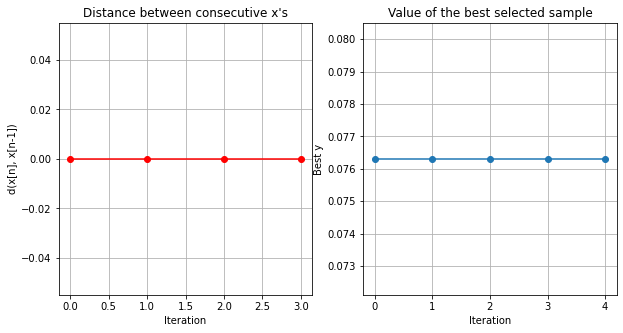

k-fold:  20%|██        | 1/5 [00:00<00:01,  2.73it/s]

not enough values to unpack (expected 2, got 0)


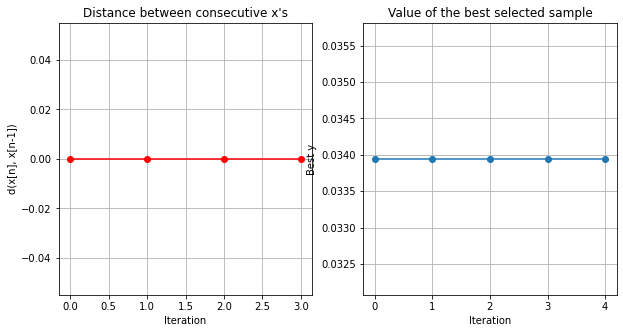

k-fold:  40%|████      | 2/5 [00:00<00:01,  2.80it/s]

not enough values to unpack (expected 2, got 0)


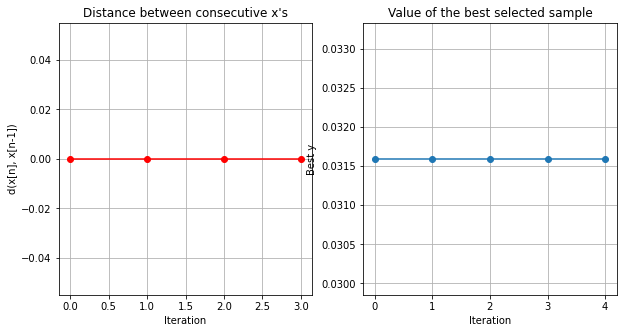

k-fold:  60%|██████    | 3/5 [00:01<00:00,  2.77it/s]

not enough values to unpack (expected 2, got 0)


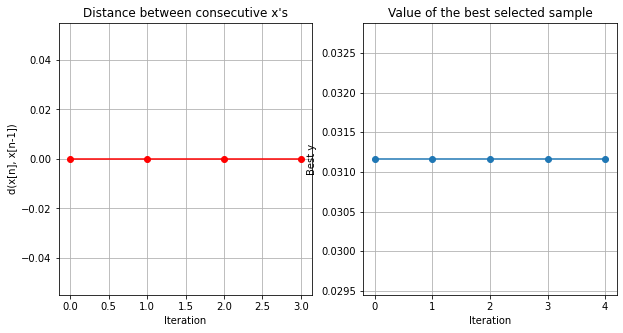

k-fold:  80%|████████  | 4/5 [00:01<00:00,  2.81it/s]

not enough values to unpack (expected 2, got 0)


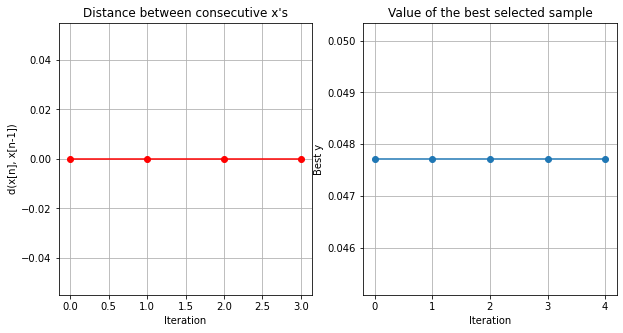

k-fold: 100%|██████████| 5/5 [00:01<00:00,  2.80it/s]

not enough values to unpack (expected 2, got 0)


In [22]:
if treinar['RegressaoLinear']:
    resultado_parcial = validacao_cruzada(Modelo=RegressaoLinear, dominio=dominio_regressao_linear, X=X_train, y=y_train, metrica=metrica)
    relatorio_modelos = pd.concat([relatorio_modelos, resultado_parcial])
    resultado_parcial.to_csv(f'resultados/parciais/RegressaoLinear_{metrica}_{fold_externo}.csv')

k-fold:   0%|          | 0/5 [00:00<?, ?it/s]

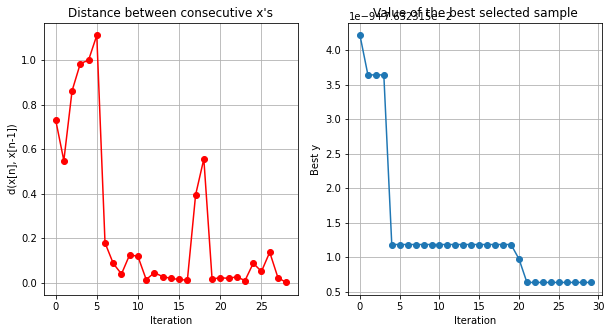

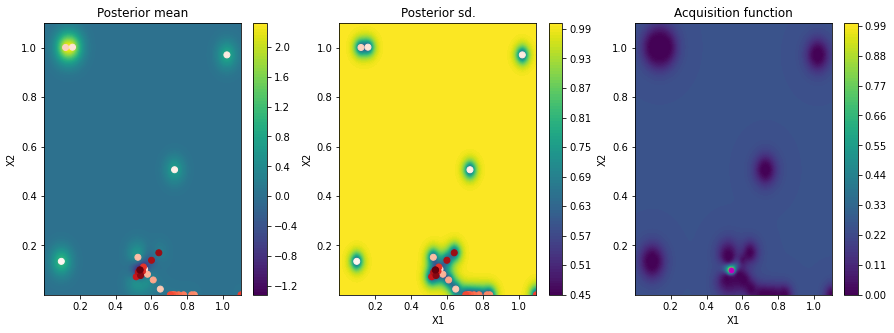

k-fold:  20%|██        | 1/5 [01:36<06:25, 96.30s/it]

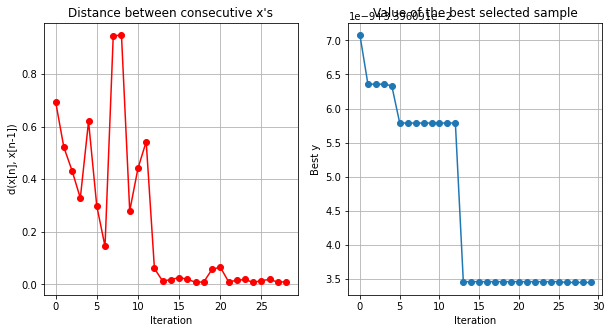

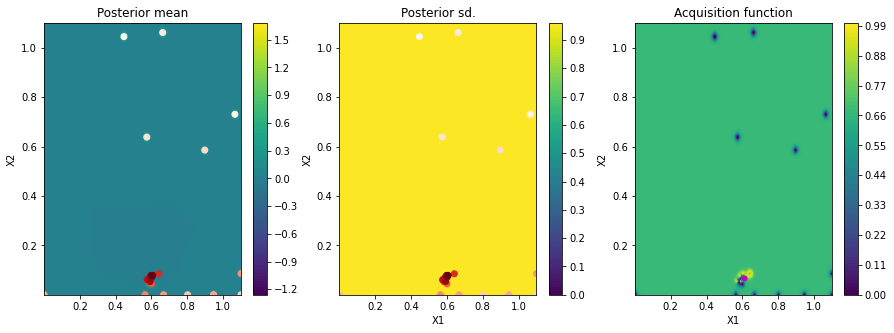

k-fold:  40%|████      | 2/5 [03:52<05:59, 119.75s/it]

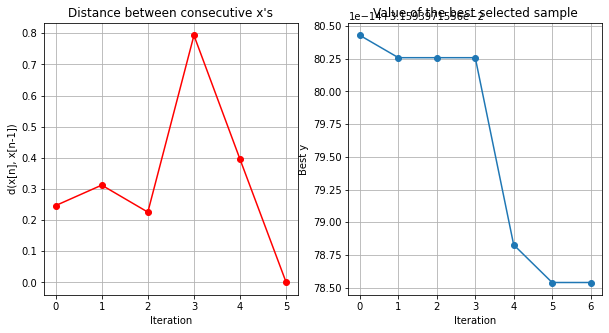

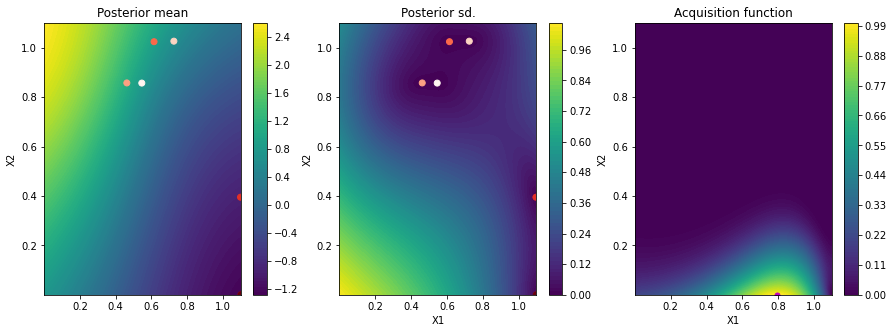

k-fold:  60%|██████    | 3/5 [03:59<02:16, 68.06s/it] 

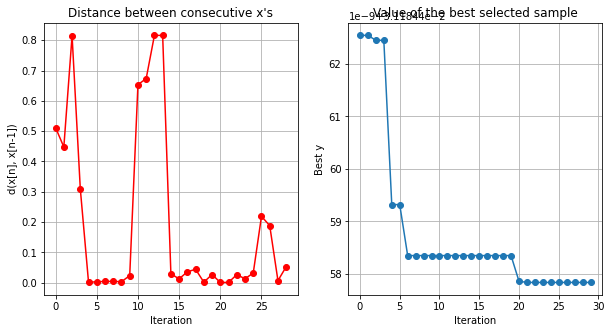

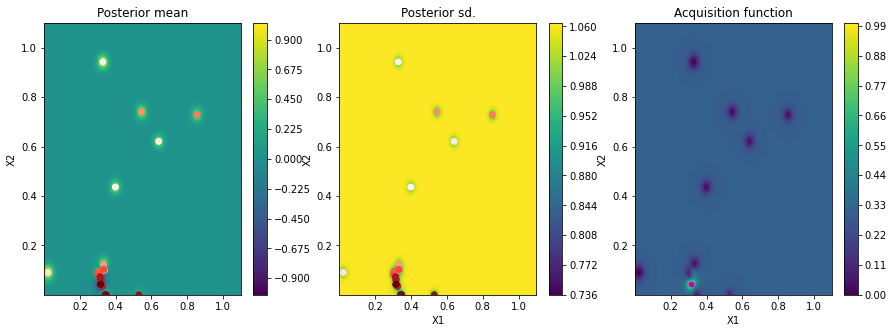

k-fold:  80%|████████  | 4/5 [05:19<01:12, 72.90s/it]

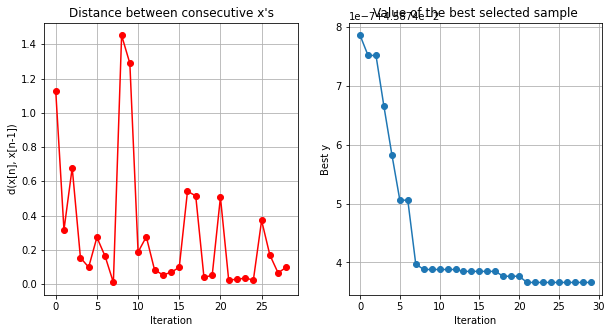

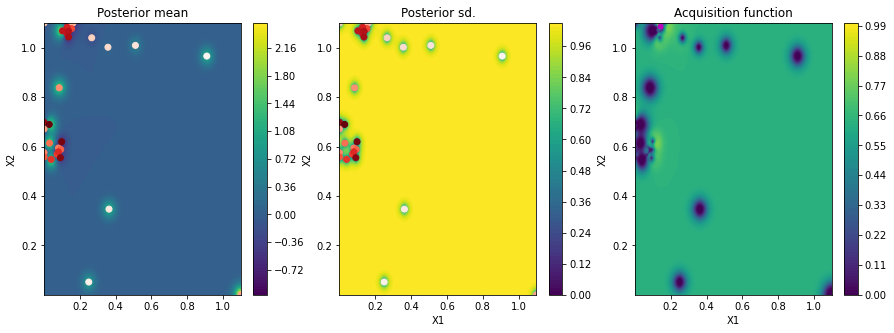

k-fold: 100%|██████████| 5/5 [07:12<00:00, 86.55s/it]


In [23]:
if treinar['BayesianLinearRegression']:
    resultado_parcial = validacao_cruzada(Modelo=BayesianLinearRegression, dominio=dominio_regressao_linear_bayesiana, X=X_train, y=y_train, metrica=metrica)
    relatorio_modelos = pd.concat([relatorio_modelos, resultado_parcial])
    resultado_parcial.to_csv(f'resultados/parciais/BayesianLinearRegression_{metrica}_{fold_externo}.csv')

k-fold:   0%|          | 0/5 [00:00<?, ?it/s]

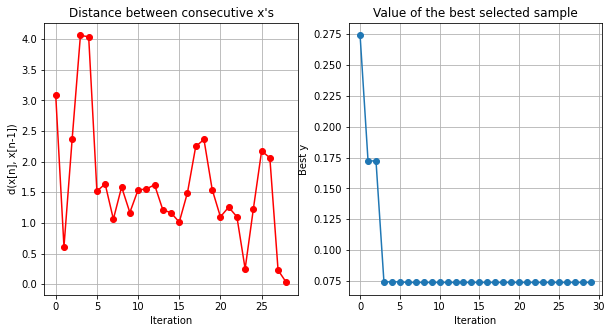

k-fold:  20%|██        | 1/5 [02:12<08:48, 132.07s/it]

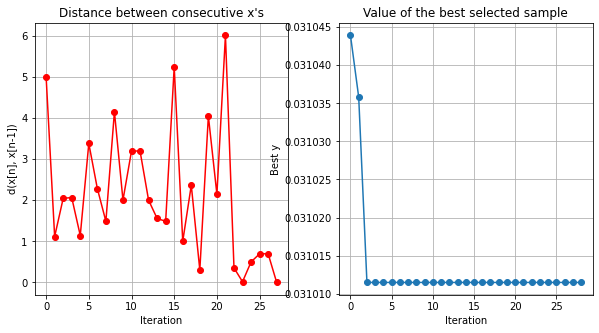

k-fold:  40%|████      | 2/5 [03:58<05:51, 117.18s/it]

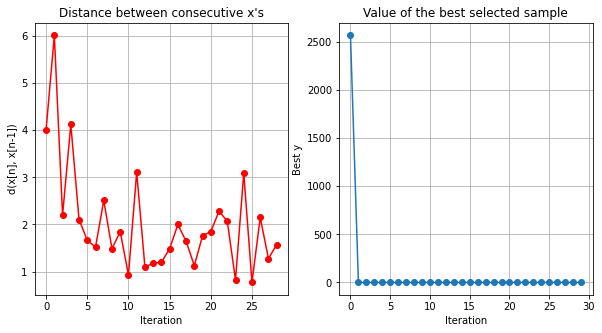

k-fold:  60%|██████    | 3/5 [05:28<03:28, 104.47s/it]

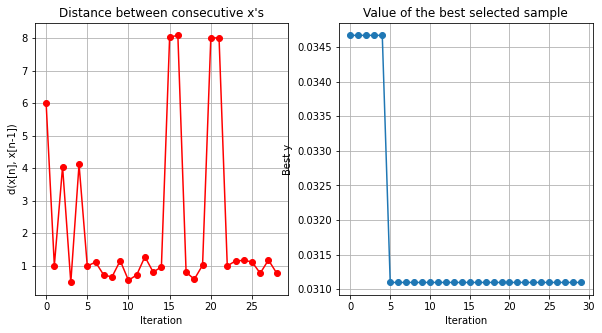

k-fold:  80%|████████  | 4/5 [06:17<01:22, 82.65s/it] 

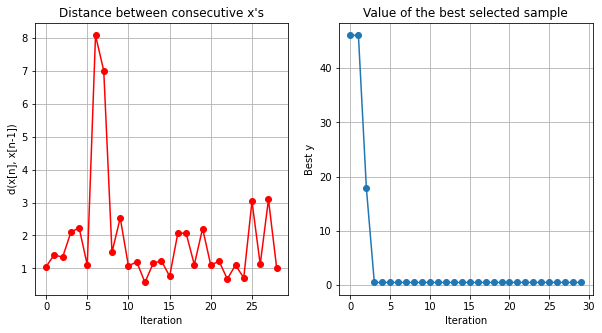

k-fold: 100%|██████████| 5/5 [07:41<00:00, 92.23s/it]


In [24]:
if treinar['BayesianPolinomialLinearRegression']:
    resultado_parcial = validacao_cruzada(Modelo=BayesianPolinomialLinearRegression, dominio=dominio_regressao_linear_bayesiana_polinomial, X=X_train, y=y_train, metrica=metrica)
    relatorio_modelos = pd.concat([relatorio_modelos, resultado_parcial])
    resultado_parcial.to_csv(f'resultados/parciais/BayesianPolinomialLinearRegression_{metrica}_{fold_externo}.csv')

k-fold:   0%|          | 0/5 [00:00<?, ?it/s]

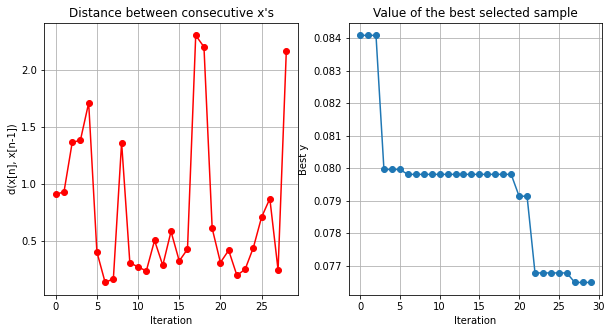

k-fold:  20%|██        | 1/5 [01:36<06:24, 96.10s/it]

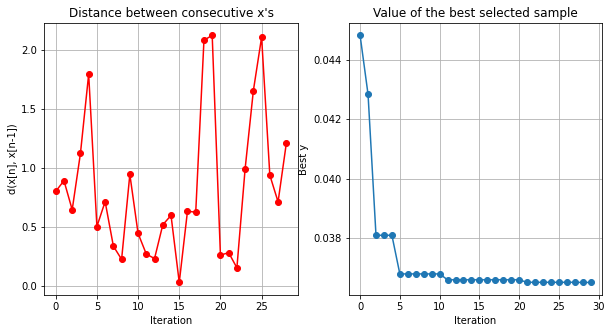

k-fold:  40%|████      | 2/5 [03:00<04:26, 88.96s/it]

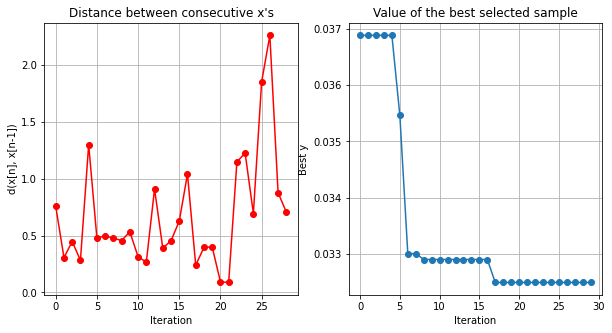

k-fold:  60%|██████    | 3/5 [04:25<02:54, 87.36s/it]

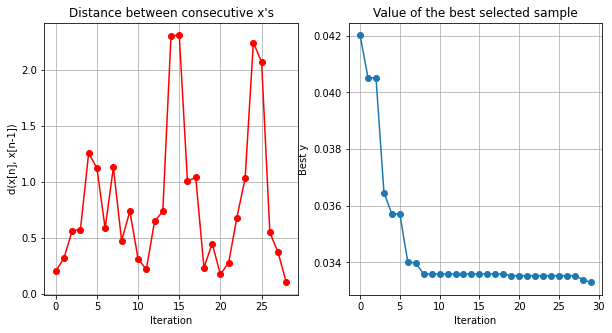

k-fold:  80%|████████  | 4/5 [05:59<01:30, 90.01s/it]

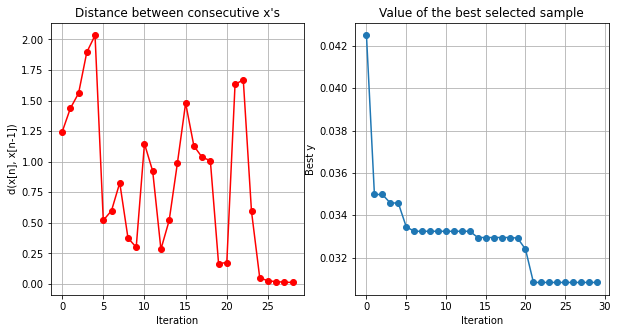

k-fold: 100%|██████████| 5/5 [07:41<00:00, 92.35s/it]


In [25]:
if treinar['RBFLinearRegression']:
    resultado_parcial = validacao_cruzada(Modelo=RBFLinearRegression, dominio=dominio_regressao_linear_bayesiana_rbf, X=X_train, y=y_train, metrica=metrica)
    relatorio_modelos = pd.concat([relatorio_modelos, resultado_parcial])
    resultado_parcial.to_csv(f'resultados/parciais/RBFLinearRegression_{metrica}_{fold_externo}.csv')

#### Resultado prelimiar

In [26]:
relatorio_condensado = relatorio_modelos.sort_values(['rmse', 'nlpd']).groupby(['modelo', 'fold']).first()
relatorio_condensado

parametros  \
modelo                             fold                                                      
BayesianLinearRegression           0     {'alphaInit': 0.5311895608442122, 'lambdaInit'...   
                                   1     {'alphaInit': 0.5929279288577197, 'lambdaInit'...   
                                   2               {'alphaInit': 1.1, 'lambdaInit': 1e-07}   
                                   3     {'alphaInit': 0.32296696027899363, 'lambdaInit...   
                                   4     {'alphaInit': 0.12888898254682277, 'lambdaInit...   
BayesianPolinomialLinearRegression 0     {'alphaInit': 0.45956177924690106, 'lambdaInit...   
                                   1     {'alphaInit': 0.35602306814555323, 'lambdaInit...   
                                   2     {'alphaInit': 1.1, 'lambdaInit': 0.0001, 'orde...   
                                   3     {'alphaInit': 0.753649973089427, 'lambdaInit':...   
                                   4     {'alphaInit': 1.1, 'lambdaInit': 1.1, 'order':...   
RBFLinearRegression                0     {'sig2_error': 0.14500884224806726, 'mean_rbf_...   
                                   1     {'sig2_error': 0.6492560527648014, 'mean_rbf_a...   
                                   2     {'sig2_error': 1.0, 'mean_rbf_arbitrario': -1....   
                                   3     {'sig2_error': 0.4083808935466747, 'mean_rbf_a...   
                                   4     {'sig2_error': 1.0, 'mean_rbf_arbitrario': -1....   
RegressaoLinear                    0                                                    {}   
                                   1                                                    {}   
                                   2                                                    {}   
                                   3                                                    {}   
                                   4                                                    {}   

                                             rmse          nlpd  
modelo                             fold                          
BayesianLinearRegression           0     0.076323  1.384911e-01  
                                   1     0.033961 -7.121890e-01  
                                   2     0.031594 -1.030446e+00  
                                   3     0.031184 -9.799982e-01  
                                   4     0.045874 -9.148238e-01  
BayesianPolinomialLinearRegression 0     0.073737  3.641489e-01  
                                   1     0.031011 -4.689830e-01  
                                   2     0.035330 -9.999573e-01  
                                   3     0.031097 -9.160605e-01  
                                   4     0.478836 -5.074629e-01  
RBFLinearRegression                0     0.076480  6.602455e-01  
                                   1     0.036505  1.397646e+00  
                                   2     0.032499  1.613349e+00  
                                   3     0.033293  1.166132e+00  
                                   4     0.030823  1.613514e+00  
RegressaoLinear                    0     0.076305  2.911245e+57  
                                   1     0.033943  5.760710e+56  
                                   2     0.031593  4.990434e+56  
                                   3     0.031164  4.855889e+56  
                                   4     0.047717  1.138467e+57

### Resultado Final (fold especificado)

In [27]:
def get_modelo(nome):
    modelos = {
        'GP': GP,
        'RegressaoLinear': RegressaoLinear,
        'BayesianPolinomialLinearRegression': BayesianPolinomialLinearRegression,
        'BayesianLinearRegression': BayesianLinearRegression,
        'RBFLinearRegression': RBFLinearRegression,
    }
    return modelos[nome]

In [29]:
relatorio = pd.DataFrame(columns=['modelo', 'parametros', 'rmse', 'nlpd', 'fold'])

X_scaler = Scaler()
y_scaler = Scaler()

X_train_fold = X_scaler.fit_transform(X_train)
X_test_fold  = X_scaler.transform(X_test)
y_train_fold = y_scaler.fit_transform(y_train)
y_test_fold  = y_scaler.transform(y_test)

for modelo, _, parametros, _, _ in tqdm(relatorio_condensado.reset_index().values):
    Modelo = get_modelo(modelo)
    f(Modelo, X_train_fold, y_train_fold, X_test_fold, y_test_fold, fold_externo, relatorio, metrica, **parametros)

# Calcular valor do RMSE do y na dimensão original
relatorio['rmse_dimensao_original'] = y_scaler.inverse_transform(relatorio.rmse.values.reshape((-1, 1)))

# Nome do arquivo
nomes_modelos = relatorio.modelo.unique()
nomes_modelos.sort()

nome_arquivo = f'resultados/final/{fold_externo}_{metrica}_{"-".join(nomes_modelos)}.csv'
relatorio.to_csv(nome_arquivo)
relatorio

100%|██████████| 20/20 [00:06<00:00,  3.28it/s]


,modelo,parametros,rmse,nlpd,fold,rmse_dimensao_original
0,BayesianLinearRegression,"{'alphaInit': 0.5311895608442122, 'lambdaInit'...",0.030070,-9.638542e-01,0,3060.451648
1,BayesianLinearRegression,"{'alphaInit': 0.5929279288577197, 'lambdaInit'...",0.030070,-9.638540e-01,0,3060.451576
2,BayesianLinearRegression,"{'alphaInit': 1.1, 'lambdaInit': 1e-07}",0.030070,-9.638545e-01,0,3060.451737
3,BayesianLinearRegression,"{'alphaInit': 0.32296696027899363, 'lambdaInit...",0.030070,-9.638541e-01,0,3060.451597
4,BayesianLinearRegression,"{'alphaInit': 0.12888898254682277, 'lambdaInit...",0.030070,-9.638550e-01,0,3060.451898
5,BayesianPolinomialLinearRegression,"{'alphaInit': 0.45956177924690106, 'lambdaInit...",0.028435,-7.919315e-01,0,2921.252391
6,BayesianPolinomialLinearRegression,"{'alphaInit': 0.35602306814555323, 'lambdaInit...",0.028153,-7.016028e-01,0,2897.195810
7,BayesianPolinomialLinearRegression,"{'alphaInit': 1.1, 'lambdaInit': 0.0001, 'orde...",0.029584,-9.174587e-01,0,3019.040408
8,BayesianPolinomialLinearRegression,"{'alphaInit': 0.753649973089427, 'lambdaInit':...",0.029584,-9.174591e-01,0,3019.040926
9,BayesianPolinomialLinearRegression,"{'alphaInit': 1.1, 'lambdaInit': 1.1, 'order':...",0.029584,-9.174590e-01,0,3019.040830
